<a href="https://colab.research.google.com/github/madch3m/tversky-similarity-grad/blob/visualization/TverskySimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the required packages to conduct tversky similarity projection layer

# Required Packages

In [ ]:

!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib

Load the toy dataset from hugging face

Split test and training data for the mnist dataset

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Download and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=500, shuffle=True)
test_loader = DataLoader(testset, batch_size=500, shuffle=False)




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(42)
np.random.seed(42)



class TverskyFeatureBank(nn.Module):
    def __init__(self, feature_bank_size, dimension_size):
        super().__init__()
        self.features = nn.Parameter(torch.randn(feature_bank_size, dimension_size))
    def forward(self):
        return self.features




In [ ]:
class TverskyProjectionLayer(nn.Module):
    def __init__(self, input_size, target_size, feature_bank_size, commonality_threshold='product', difference_threshold='ignore', normalize=False):
        super().__init__()

        self.prototypes = nn.Parameter(torch.randn(target_size,input_size))
        self.feature_bank = TverskyFeatureBank(feature_bank_size, input_size)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(0.5))
        self.theta = nn.Parameter(torch.tensor(2.0))
        self.commonality_threshold = commonality_threshold
        self.difference_threshold = difference_threshold
        self.normalize = normalize

    def compute_similarity(self, x, features):
        dot_products = torch.matmul(x,features.T)
        mask = (dot_products > 0).float()
        return (dot_products * mask).sum(dim=-1)

    def compute_commonality(self, a_dot_prod, b_dot_prod):
        mask = ((a_dot_prod > 0) & (b_dot_prod > 0)).float()

        if self.commonality_threshold == 'product':
            return (a_dot_prod * b_dot_prod * mask).sum(dim=-1)
        elif self.commonality_threshold == 'sum':
            return (a_dot_prod + b_dot_prod * mask).sum(dim=-1)
        elif self.commonality_threshold == 'min':
            return (torch.min(a_dot_prod, b_dot_prod) * mask).sum(dim=-1)
        elif self.commonality_threshold == 'max':
            return (torch.max(a_dot_prod, b_dot_prod) * mask).sum(dim=-1)
        elif self.commonality_threshold == 'mean':
            return ((a_dot_prod  + b_dot_prod) / 2 * mask).sum(dim=-1)
        else:
            raise ValueError(f"Unknown commonality threshold: {self.commonality_threshold}")

    def compute_difference(self, a_dot_prod, b_dot_prod):
        if self.difference_threshold == 'ignore':
            mask = ((a_dot_prod > 0) & (b_dot_prod <= 0)).float()
            return (a_dot_prod * mask).sum(dim=-1)

        elif self.difference_threshold == 'deduplication':
            mask = ((a_dot_prod > 0) & (b_dot_prod <= 0)).float()
            return (a_dot_prod * mask).sum(dim=-1)


    def forward(self, x):
        features = self.feature_bank()
        if self.normalize:
            x = torch.nn.functional.normalize(x, p=2,dim=-1)
            self.prototypes.data = torch.nn.functional.normalize(self.prototypes.data, p=2, dim=-1)
            features = torch.nn.functional.normalize(features, p=2, dim=-1)
        batch_size = x.size(0)
        num_prototypes = self.prototypes.size(0)

        x_dots = torch.matmul(x, features.T)

        similarities = []

        for i in range(num_prototypes):
            prototype_dots = torch.matmul(self.prototypes[i: i+1],features.T)
            prototype_dots = prototype_dots.expand(batch_size, -1)

            commonalities = self.compute_commonality(x_dots, prototype_dots)
            differences_x = self.compute_difference(x_dots, prototype_dots)
            difference_prototypes = self.compute_difference(prototype_dots, x_dots)


            similarity_x = self.theta * commonalities - self.alpha * differences_x
            similarities.append(similarity_x)

        return torch.stack(similarities, dim=-1)


In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(12,12, kernel_size=3)
        self.conv3 = nn.Conv2d(12,12,kernel_size=3)

        self.fc1 = nn.Linear(12 * 3 * 3, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class TverskyMinstModel(nn.Module):
    def __init__(self, num_features=20):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=3)
        self.conv3 = nn.Conv2d(12, 12, kernel_size=3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 1))
        self.tversky_layer = TverskyProjectionLayer(input_size=36, target_size=10, feature_bank_size=num_features,commonality_threshold='product',difference_threshold='ignore', normalize=True)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        x = self.tversky_layer(x)
        return x


In [ ]:
def train_mnist_model(model, epochs=10, lr=0.002):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criteria = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, y_pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (y_pred == labels).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, test_accuracies

In [ ]:
Mnist_model = MnistModel()
base_loss, base_acc = train_mnist_model(Mnist_model)


Epoch 1/10], Loss: 0.6945, Test Accuracy: 0.94%
Epoch 2/10], Loss: 0.1592, Test Accuracy: 0.97%
Epoch 3/10], Loss: 0.1092, Test Accuracy: 0.98%
Epoch 4/10], Loss: 0.0883, Test Accuracy: 0.98%
Epoch 5/10], Loss: 0.0769, Test Accuracy: 0.98%
Epoch 6/10], Loss: 0.0682, Test Accuracy: 0.98%
Epoch 7/10], Loss: 0.0622, Test Accuracy: 0.99%
Epoch 8/10], Loss: 0.0588, Test Accuracy: 0.99%
Epoch 9/10], Loss: 0.0519, Test Accuracy: 0.99%
Epoch 10/10], Loss: 0.0490, Test Accuracy: 0.99%


In [ ]:
tverksey_minst_model = TverskyMinstModel(num_features=20)
tversky_loss, tversky_acc = train_mnist_model(tverksey_minst_model)

Epoch 1/10], Loss: 1.8139, Test Accuracy: 0.66%
Epoch 2/10], Loss: 1.0287, Test Accuracy: 0.84%
Epoch 3/10], Loss: 0.6882, Test Accuracy: 0.88%
Epoch 4/10], Loss: 0.5245, Test Accuracy: 0.91%
Epoch 5/10], Loss: 0.4272, Test Accuracy: 0.93%
Epoch 6/10], Loss: 0.3530, Test Accuracy: 0.94%
Epoch 7/10], Loss: 0.3063, Test Accuracy: 0.95%
Epoch 8/10], Loss: 0.2725, Test Accuracy: 0.95%
Epoch 9/10], Loss: 0.2473, Test Accuracy: 0.95%
Epoch 10/10], Loss: 0.2254, Test Accuracy: 0.96%


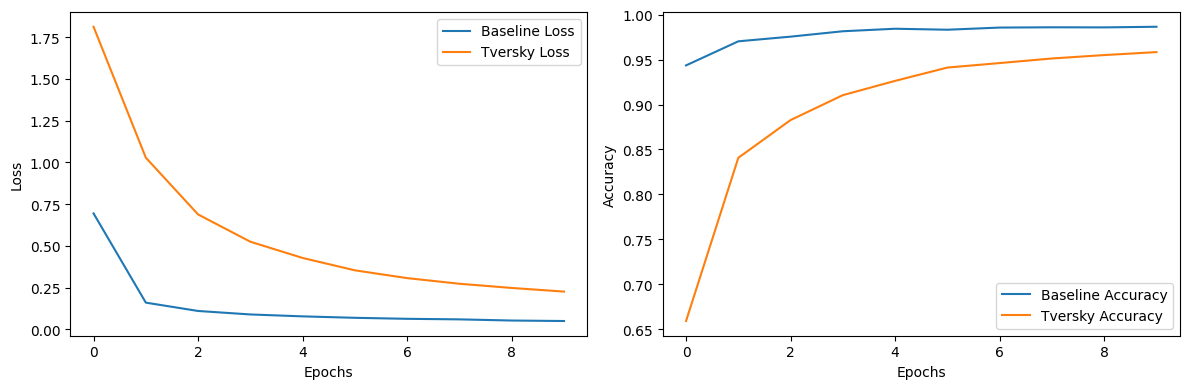

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(base_loss, label='Baseline Loss')
plt.plot(tversky_loss, label='Tversky Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(base_acc, label='Baseline Accuracy')
plt.plot(tversky_acc, label='Tversky Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Stub class for initating the tversky model for feature bank

Method for setting the scalars alpha and beta to ensure that they are differentiable

Compute prototypes for each of the features within the feature bank size and the input

##Tversky GPT Layer to reduce size of model overall

In [ ]:
from transformers import GPT2Model, GPT2Config

class GPTAttentionBlock(nn.Module):
    def __init__(self, d_model, nheads, dropout=0.1, max_seq_length=1024, use_tversky=False, tversky_alpha=0.5,tversky_beta=0.4):
        super().__init__()

        self.d_model = d_model
        self.nheads = nheads
        self.head_dim = d_model // nheads
        self.dropout = dropout
        self.max_seq_length = max_seq_length
        self.use_tversky = use_tversky
        self.tversky_alpha = tversky_alpha
        self.tversky_beta = tversky_beta
        #multihead attention using combined attention value for the attention weight vector
        self.c_attn = nn.Linear(d_model, 3 * d_model)
        self.c_proj = nn.Linear(d_model, d_model)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        self.ln = nn.LayerNorm(d_model)



In [ ]:
class multiAttentionHead(nn.Moduel):
    def __init__(self, d_in, d_out, context_len, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.d_in = d_in
        self.head = num_heads
        self.head_dim = d_out // num_heads
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.attn_dropout = nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_len, context_len),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_k(x)
        weights = self.W_q(x)
        values = self.W_v(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        weights = weights.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        attn_scores = queries @ keys.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = (attn_weights @ values).transpose(1,2)
        context = context.contiguous().view(b, num_tokens, self.d_out)
        context = self.proj(context)
        return context
